In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

from torchts.nn.loss import quantile_loss
from torchts.nn.model import TimeSeriesModel
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility

In [2]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

# Generate data

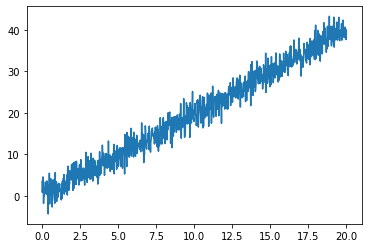

In [3]:
# generate linear time series data with some noise
n = 1000
x_max = 20
slope = 2
scale = 2

x = torch.from_numpy(np.linspace(0, x_max, n).reshape(-1, 1).astype(np.float32))
y = slope * x + np.random.normal(0, scale, n).reshape(-1, 1).astype(np.float32)

plt.plot(x, y)
plt.show()

### Split data set

In [4]:
# split to three sections
window_size = n//3
if n % 3 == 0:
    # If an even split of data, then give each dataset n//3 entries
    x_train = x[:window_size]
    x_cal = x[window_size:window_size*2]
    x_test = x[window_size*2:]
    y_train = y[:window_size]
    y_cal = y[window_size:window_size*2]
    y_test = y[window_size*2:]
elif n % 3 == 1:
    # if there's 1 left, it automatically gets added to the test set
    x_train = x[:window_size]
    x_cal = x[window_size:window_size*2]
    x_test = x[window_size*2:]
    y_train = y[:window_size]
    y_cal = y[window_size:window_size*2]
    y_test = y[window_size*2:]
elif n % 3 == 2:
    # if there's 2 extra data points, add one to calibration, then other extra will go towards test
    x_train = x[:window_size]
    x_cal = x[window_size:window_size*2+1]
    x_test = x[window_size*2:]
    y_train = y[:window_size]
    y_cal = y[window_size:window_size*2+1]
    y_test = y[window_size*2:]

In [5]:
# scaler = StandardScaler()


# # Scale the y data locally (ex. train scaled to train)
# y_train_scaled = scaler.fit_transform(y_train)
# y_cal_scaled = scaler.fit_transform(y_cal)
# y_test_scaled = scaler.fit_transform(y_test)

# # scaler.fit(y_train)
# # # Scale based on training set
# # y_train_scaled = scaler.transform(y_train)
# # y_cal_scaled = scaler.transform(y_cal)
# # y_test_scaled = scaler.transform(y_test)


# # Scale the x data locally (ex. train scaled to train)
# x_train_scaled = scaler.fit_transform(x_train)
# x_cal_scaled = scaler.fit_transform(x_cal)
# x_test_scaled = scaler.fit_transform(x_test)

# # Convert our scaled data into tensors of type float since that is what our torchTS model expects
# y_train = torch.tensor(y_train_scaled).float()
# y_cal = torch.tensor(y_cal_scaled).float()
# y_test = torch.tensor(y_test_scaled).float()

# x_train = torch.tensor(x_train_scaled).float()
# x_cal = torch.tensor(x_cal_scaled).float()
# x_test = torch.tensor(x_test_scaled).float()

In [6]:
# # Split our training dataset into training and calibration sets randomly
# # and correct to maintain the timeseries convention of ascending x
# idx = np.random.permutation(n)
# n_half = int(np.floor(n/2))
# idx_train, idx_cal = np.sort(idx[:n_half]), np.sort(idx[n_half:2*n_half])

# # Perform split using our split indices
# x_train = x.numpy()[idx_train]
# x_cal = x.numpy()[idx_cal]

# y_train = y.numpy()[idx_train]
# y_cal = y.numpy()[idx_cal]

# plt.plot(torch.tensor(x_train), torch.tensor(y_train))
# plt.show()

# plt.plot(torch.tensor(x_cal), torch.tensor(y_cal))
# plt.show()

# x_train = torch.tensor(x_train)
# y_train = torch.tensor(y_train)
# x_cal = torch.tensor(x_cal)
# y_cal = torch.tensor(y_cal)

# Define model that predicts quantiles

In [7]:
class QuantileLSTM(TimeSeriesModel):
    def __init__(
        self, input_size, output_size, hidden_size, optimizer, quantile=0.5, method=None,significance=None, **kwargs
    ):
        super().__init__(
            optimizer,
            criterion=quantile_loss,
            criterion_args={"quantile": quantile},
            method=method,
            significance=significance,
            **kwargs
        )
        n_quantiles = 1 if isinstance(quantile, float) else len(quantile)
        self.lstm = nn.ModuleList(
            [nn.LSTMCell(input_size, hidden_size) for _ in range(output_size)]
        )
        self.linear = nn.ModuleList(
            [nn.Linear(hidden_size, n_quantiles) for _ in range(output_size)]
        )

    def forward(self, x, y=None, batches_seen=None):
        hidden, _ = zip(*[m(x) for m in self.lstm])
        out = [m(h) for m, h in zip(self.linear, hidden)]
        return torch.hstack(out)

# Train model to predict a single quantile

In [8]:
# # train model
# model.fit(x_train, y_train, max_epochs=max_epochs, batch_size=batch_size)
# # model.fit(x, y, max_epochs=max_epochs, batch_size=batch_size)
# # inference
# y_cal_preds = model.predict(x_cal)

In [9]:
# plt.plot(x_cal, y_cal, label="y_true")
# plt.plot(x_cal, y_cal_preds, label=f"p={quantile}")
# plt.legend()
# plt.show()

# Train model to predict multiple quantiles

In [13]:
scaler= StandardScaler()
scaler.fit_transform(x_train)

array([[-1.72685724e+00],
       [-1.71645449e+00],
       [-1.70605173e+00],
       [-1.69564898e+00],
       [-1.68524623e+00],
       [-1.67484347e+00],
       [-1.66444071e+00],
       [-1.65403796e+00],
       [-1.64363521e+00],
       [-1.63323245e+00],
       [-1.62282970e+00],
       [-1.61242694e+00],
       [-1.60202418e+00],
       [-1.59162144e+00],
       [-1.58121867e+00],
       [-1.57081592e+00],
       [-1.56041318e+00],
       [-1.55001041e+00],
       [-1.53960766e+00],
       [-1.52920490e+00],
       [-1.51880215e+00],
       [-1.50839940e+00],
       [-1.49799664e+00],
       [-1.48759389e+00],
       [-1.47719113e+00],
       [-1.46678838e+00],
       [-1.45638563e+00],
       [-1.44598288e+00],
       [-1.43558010e+00],
       [-1.42517736e+00],
       [-1.41477461e+00],
       [-1.40437186e+00],
       [-1.39396911e+00],
       [-1.38356633e+00],
       [-1.37316358e+00],
       [-1.36276084e+00],
       [-1.35235809e+00],
       [-1.34195534e+00],
       [-1.3

In [10]:
input_size = 1
output_size = 1
hidden_size = 16
optimizer = optim.Adam
optimizer_args = {"lr": 0.05}
max_epochs =1000
batch_size = 10
quantile = [0.025, 0.5, 0.975]

model = QuantileLSTM(
    input_size,
    output_size,
    hidden_size,
    optimizer,
    quantile=quantile,
    method='conformal',
    significance=0.1,
    optimizer_args=optimizer_args,
    scaler= StandardScaler()
)

In [11]:
model.fit(x, y, max_epochs=max_epochs, batch_size=batch_size)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/judyyy/opt/anaconda3/envs/spatiotemporal/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name   | Type       | Params
--------------------------------------
0 | lstm   | ModuleList | 1.2 K 
1 | linear | ModuleList | 51    
--------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
/Users/judyyy/opt/anaconda3/envs/spatiotemporal/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the valu

Epoch 0:   0%|                                            | 0/1 [00:00<?, ?it/s]

NameError: name 'fit_transform' is not defined

In [16]:
y_pred_conformal = model.conformal_predict(x)

/Users/judyyy/opt/anaconda3/envs/spatiotemporal/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------

                                                                                


Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------

                                                                                

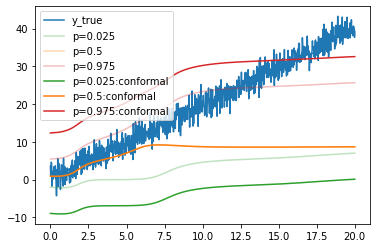

In [17]:
y_pred = model.predict(x)
y_pred_conformal = model.conformal_predict(x)
n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

plt.plot(x, y, label="y_true")

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(x, y_pred[:, i], c=cycle_colors[c], label=f"p={quantile[i]}",alpha = 0.3)

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(x, y_pred_conformal[:, i], c=cycle_colors[c], label=f"p={quantile[i]}:conformal")
plt.legend()
plt.show()

In [14]:
model.err_dist

array([[7.9344234],
       [7.9344234]], dtype=float32)

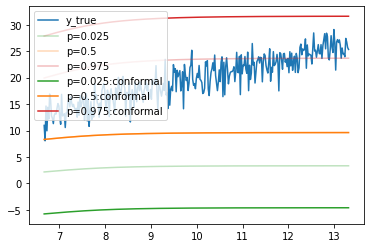

In [15]:
y_pred_cal = model.predict(x_cal)
y_pred_cal_con = model.conformal_predict(x_cal)
n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

plt.plot(x_cal, y_cal, label="y_true")

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(x_cal, y_pred_cal[:, i], c=cycle_colors[c], label=f"p={quantile[i]}",alpha = 0.3)
for i, c in zip(range(n_quantiles), color_index):
    plt.plot(x_cal, y_pred_cal_con[:, i], c=cycle_colors[c], label=f"p={quantile[i]}:conformal")

    
plt.legend()
plt.show()

In [26]:
# train model
model.fit(x_train, y_train, max_epochs=max_epochs, batch_size=batch_size)
# model.fit(x, y, max_epochs=max_epochs, batch_size=batch_size)
# inference
y_cal_preds = model.predict(x_cal)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name   | Type       | Params
--------------------------------------
0 | lstm   | ModuleList | 1.2 K 
1 | linear | ModuleList | 51    
--------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


/Users/judyyy/opt/anaconda3/envs/spatiotemporal/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/judyyy/opt/anaconda3/envs/spatiotemporal/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/judyyy/opt/anaconda3/envs/spatiotemporal/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the l

Epoch 0:  50%|▌| 1/2 [00:00<00:00, 94.29it/s, loss=2.5, v_num=43, train_loss_ste
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|█| 2/2 [00:00<00:00, 59.59it/s, loss=2.5, v_num=43, train_loss_ste
Epoch 1:  50%|▌| 1/2 [00:00<00:00, 76.87it/s, loss=2.27, v_num=43, train_loss_st
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|█| 2/2 [00:00<00:00, 55.89it/s, loss=2.27, v_num=43, train_loss_st
Epoch 2:  50%|▌| 1/2 [00:00<00:00, 76.98it/s, loss=2.08, v_num=43, train_loss_st
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|█| 2/2 [00:00<00:00, 58.23it/s, loss=2.08, v_num=43, train_loss_st
Epoch 3:  50%|▌| 1/2 [00:00<00:00, 100.47it/s, loss=1.97, v_num=43, train_loss_s
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|█| 2/2 [00:00<00:00, 63.01it/s, loss=1.97, v_num=43, train_loss_st
Epoch 4:  50%|▌| 1/2 [00:00<00:00, 99.20it/s, loss=1.88, v_num=43, train_loss_st
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|█| 2/2 [00:00<00:00, 61.71it/s, loss=1.88, v_num=43, train_loss_st
Epoch 5:  50%|▌| 1/2 [00:00<00:00, 

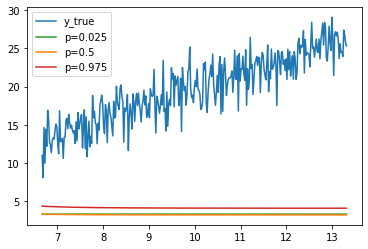

In [27]:
# n_quantiles = len(quantile)
# cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# color_index = [2, 1, 3]

# plt.plot(x, y, label="y_true")

# for i, c in zip(range(n_quantiles), color_index):
#     plt.plot(x, y_preds[:, i], c=cycle_colors[c], label=f"p={quantile[i]}")

# plt.legend()
# plt.show()

n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

plt.plot(x_cal, y_cal, label="y_true")

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(x_cal, y_cal_preds[:, i], c=cycle_colors[c], label=f"p={quantile[i]}")

plt.legend()
plt.show()

### Begin implementation of conformal prediction code

In [48]:
def quantile_err(prediction, y):
    """
    prediction: arr where first 3 columns are: lower quantile, middle quantile (50%), upper quantile in that order
    """
    y_lower = prediction[:, 0]
    y_upper = prediction[:, 2]
    # Calculate error on our predicted upper and lower quantiles
    # this will get us an array of negative values with the distance between the upper/lower quantile and the
    # 50% quantile
    error_low = y_lower - y
    error_high = y - y_upper
    # Make an array where each entry is the highest error when comparing the upper and lower bounds for that entry prediction 
    err = np.maximum(error_high, error_low)
    return err

In [49]:
# Find quantile error of our model
quantile_err(y_cal_preds, y_cal[:, 0])

tensor([-0.2157, -1.1425, -0.5725, -1.0078, -1.1158, -1.0800, -0.9064, -0.5258,
        -1.1967, -0.7940, -0.7273, -0.8658, -0.9925, -1.1612, -0.6423, -0.9134,
        -1.0952, -0.5000, -0.6431, -0.4628, -0.7690, -1.0903, -0.7029, -0.8152,
        -0.9817, -0.7399, -1.1772, -0.8447, -1.1123, -0.9609, -1.0965, -0.4948,
        -1.1143, -1.0927, -0.4527, -0.4197, -0.4318, -0.8455, -0.4288, -0.4211,
        -0.7094, -0.5409, -0.4197, -0.6056, -0.4322, -0.8403, -0.3695, -0.3885,
        -0.5792, -0.8438, -0.7676, -0.5641, -0.8771, -0.7292, -0.7396, -0.0866,
        -0.6764, -0.4695, -0.2241, -0.4501, -0.3191, -0.1381, -0.6174, -0.6701,
        -0.1606, -0.5815, -0.2052])

In [50]:
# store our quantile errors into variable named for calibration scores
cal_scores = quantile_err(y_cal_preds, y_cal[:, 0])

In [51]:
# Make a dictionary where our calibration scores (errors) are sorted in descending order
nc = {0: np.sort(cal_scores, 0)[::-1]}

In [52]:
# Specify significance we would like to see for our coverage when dealing with conformal prediction
significance = .1

In [53]:
# Sort calibration scores in ascending order? TODO make sure this is correct
# this is the apply_inverse portion of RegressorNC predict function
nc = np.sort(cal_scores,0)

index = int(np.ceil((1-significance) * (nc.shape[0] + 1))) - 1
# find largest error that gets us guaranteed coverage
index = min(max(index, 0), nc.shape[0] - 1)

err_dist = np.vstack([nc[index], nc[index]])

In [54]:
index

61

In [55]:
err_dist

array([[-0.22408685],
       [-0.22408685]], dtype=float32)

In [56]:
# store the predictions from our nonconformal quantile regressor
prediction = y_cal_preds

In [57]:
intervals = np.zeros((x_cal.shape[0],3))
# TODO ensure that we want to multiply our error distances by the size of our training set
err_dist = np.hstack([err_dist] * x_cal.shape[0])

In [58]:
prediction.shape

torch.Size([67, 3])

In [59]:
# CQR

# grab the first and last intervals predicted from our nonconformal quantile regressor in order to
# calculate our new intervals that fit our coverage requirements
intervals[:, 0] = prediction[:,0] - err_dist[0, :]
intervals[:, 1] = prediction[:,1]
intervals[:, 2] = prediction[:, -1] + err_dist[1,:]

conformal_intervals = intervals

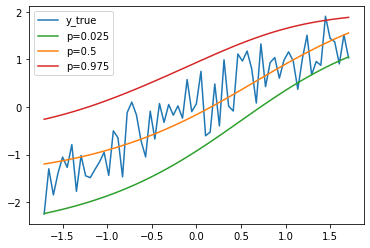

In [60]:
# n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

plt.plot(x_cal, y_cal, label="y_true")

for i, c in zip(range(len(conformal_intervals)), color_index):
    plt.plot(x_cal, conformal_intervals[:, i], c=cycle_colors[c], label=f"p={quantile[i]}")

plt.legend()
plt.show()

# End of conformal implementation

# Add second response variable

In [26]:
# y_max = slope * x_max
# y2 = 2 * y_max / (1 + np.exp(-x)) - y_max
# y2 += np.random.normal(0, scale, n).reshape(-1, 1).astype(np.float32)
# y = torch.hstack([y, y2])

# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(x, y[:, 0])
# plt.subplot(1, 2, 2)
# plt.plot(x, y[:, 1])
# plt.show()

# Train model to predict quantiles for two response variables

In [ ]:
# output_size = 2

# model = QuantileLSTM(
#     input_size,
#     output_size,
#     hidden_size,
#     optimizer,
#     quantile=quantile,
#     optimizer_args=optimizer_args,
# )

In [ ]:
# # train model
# model.fit(x, y, max_epochs=max_epochs, batch_size=batch_size)

# # inference
# y_preds = model.predict(x)

In [ ]:
# plt.figure(figsize=(12, 4))

# plt.subplot(1, 2, 1)
# plt.plot(x, y[:, 0], label="y_true")

# for i, c in zip(range(n_quantiles), color_index):
#     plt.plot(x, y_preds[:, i], c=cycle_colors[c], label=f"p={quantile[i]}")

# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(x, y[:, 1], label="y_true")

# for i, c in zip(range(n_quantiles), color_index):
#     plt.plot(x, y_preds[:, i + n_quantiles], c=cycle_colors[c], label=f"p={quantile[i]}")

# plt.legend()

# plt.show()